## 1. Introduction
## 2. Load and check data
 - 2.1 load data
 - 2.2 Outlier detection
 - 2.3 Joining train and test set
 - 2.4 check for null and missing values
 
## 3. Feature analysis
 - 3.1 Numerical values
 - 3.2 Categorical values
 
## 4. Filling missing values
 - 4.1 Age
 
## 5. Feature engineering
 - 5.1 Name/Title
 - 5.2 Family Size
 - 5.3 Cabin
 - 5.4 Ticket
 
## 6. Modeling
 ### 6.1 Simple Modeling
  - 6.1.1 Cross validate models
  - 6.1.2 Hyperparater tuning for best models
  - 6.1.3 Plot learning curves
  - 6.1.4 Feature Importance of the tree based classifiers
 ### 6.2 Ensemble modeling
  - 6.2.1 Combining models
 ### 6.3 Prediction
  - 6.3.1 Predict and Submit results

# 1. Introduction
- Feature analysis
- Feature engineering
- Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='white', context='notebook', palette='deep')

# 2. Load and check data
2.1 Load data

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
IDtest = test['PassengerId']

2.2 Outlier detection
이상값은 예측력에 상당한 문제를 일으킬 수 있기 때문에, 관리해준다

Tukey의 방법을 사용해서 이상치를 검측했습니다. 이는 분포의 1st와 3rd 사이의 (IQR) interquartile 범위를 정의하는 방법이다. 하나의 이상치는 IQR +- an outlier step의 밖에 있는 변수를 갖는 샘플이다.

이상치를 수치형 변수 (Age, SibSp, Parch, Fare)에서 찾기로 하였다. 그리고 2개 이상의 이상치 수치형 변수로 정의하여 row를 선택한다

In [3]:
from collections import Counter
def detect_outliers(df, n, features):
    """
    데이터프레임을 받아서 아웃라이어의 인덱스를 반환하는 함수
    """

    outlier_indices = []
    # 모든 feature에 대하여
    for col in features:
        # IQR
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5*IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step)|(df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v>n)
    return multiple_outliers

cols = ['Age', 'SibSp', 'Parch', 'Fare']
Outliers_to_drop = detect_outliers(train, 2, cols)
print(f"The Outlier sample indices is {Outliers_to_drop}")

The Outlier sample indices is [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


We detect 10 outliers. The 28, 89, 342 passenger have an high Ticket Fare. The 7 others jave very high values of SibSp.

In [4]:
# Show the outliers rows
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
# Drop outliers
train.drop(Outliers_to_drop, axis=0, inplace=True)
train.reset_index(drop=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


2.3 Joining train and test set

train과 test 데이터셋을 합쳐서 categorical conversion을 위해 동일한 숫자의 feature를 갖는다

In [6]:
train_len = len(train)
dataset = pd.concat([train,test], axis=0).reset_index(drop=True)
dataset.shape

(1299, 12)

2.4 check for null and missing values

Age와 Cabin은 결측값 처리가 굉장히 중요하다.
survived는 test 데이터를 합쳐서 생긴 것이므로 괜찮

In [7]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 89.5+ KB


In [9]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# 3. Feature analysis

## 3.1 Numerical values

- 오직 Fare만 생존과 어느정도 상관관계가 있는 것으로 보임
- 이것이 다른 변수가 쓸모 없다는 말은 아니다. subpopulations는 생존과 연관이 있을 수 있음. 이를 확인하기 위해 우리는 더 깊이 살펴볼 필요가 있음

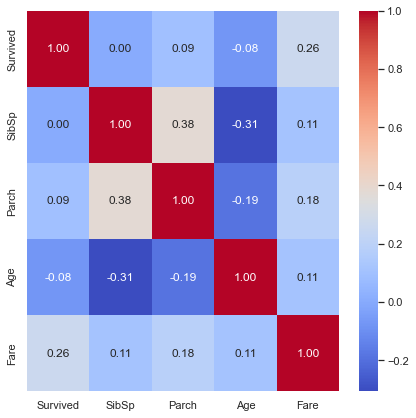

In [10]:
# Correlation matrix between numerical values
numerical = ['Survived', 'SibSp', 'Parch', 'Age', 'Fare']
corr = train[numerical].corr('pearson')
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.show()

- 관측결과

Survived는 Numerical feature중에서 Fare와만 약간의 상관관계가 있어 보임. 하지만 이것이 다른 feature는 중요하지 않다를 의미하지는 않음. 좀 더 자세히 살펴보자

### SibSp

In [11]:
import warnings
warnings.filterwarnings('ignore')

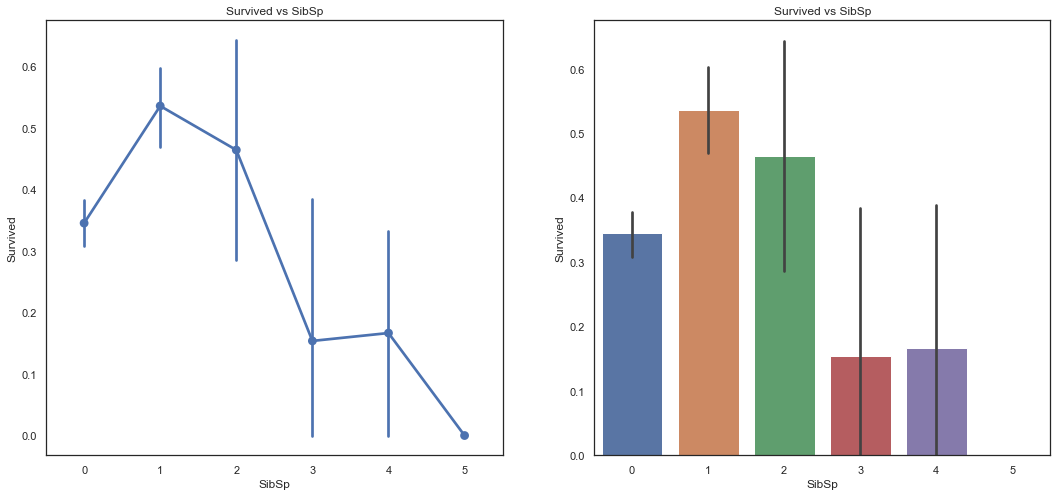

In [12]:
f, ax = plt.subplots(1,2, figsize=(18,8))
sns.pointplot('SibSp', 'Survived', data=train, ax=ax[0])
ax[0].set_title('Survived vs SibSp')
sns.barplot('SibSp', 'Survived', data=train, ax=ax[1])
ax[1].set_title('Survived vs SibSp')
plt.show()

- 관측 결과

1) SibSp: 형제 혹은 배우자의 수를 의미하는 변수로 3이 넘어가면 생존률이 굉장히 낮아지는 것을 확인할 수 있음
2) 0은 혼자 탑승한 것으로 오히려 1과 2보다 낮은 것을 알 수 있음

### Parch

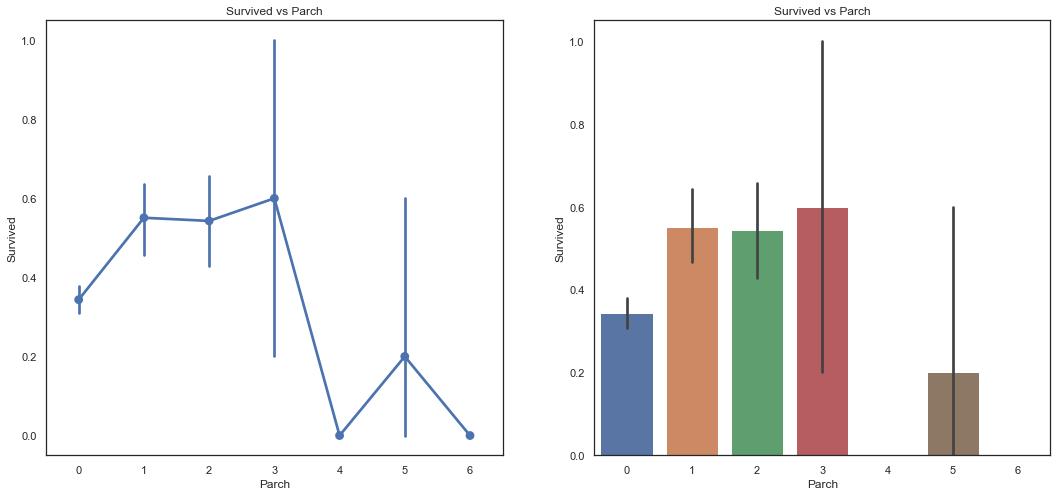

In [13]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
sns.pointplot('Parch', 'Survived', data=train, ax=ax[0])
ax[0].set_title('Survived vs Parch')
sns.barplot('Parch', 'Survived', data=train, ax=ax[1])
ax[1].set_title('Survived vs Parch')
plt.show()

- 관측 결과
1) Parch는 부모 세대의 수로 4가 넘어가면 굉장히 확률이 낮아지는 것을 확인할 수 있음.
2) 0은 혼자 탑승한 것으로 오히려 1,2,3 보다 낮은 것을 확인할 수 있다.
3) SibSp과 굉장히 유사한 변수이고 서로 비슷한 경향을 보여줌
4) 상관관계도 0.38로 두 변수가 서로 관계되어 있음

### Age

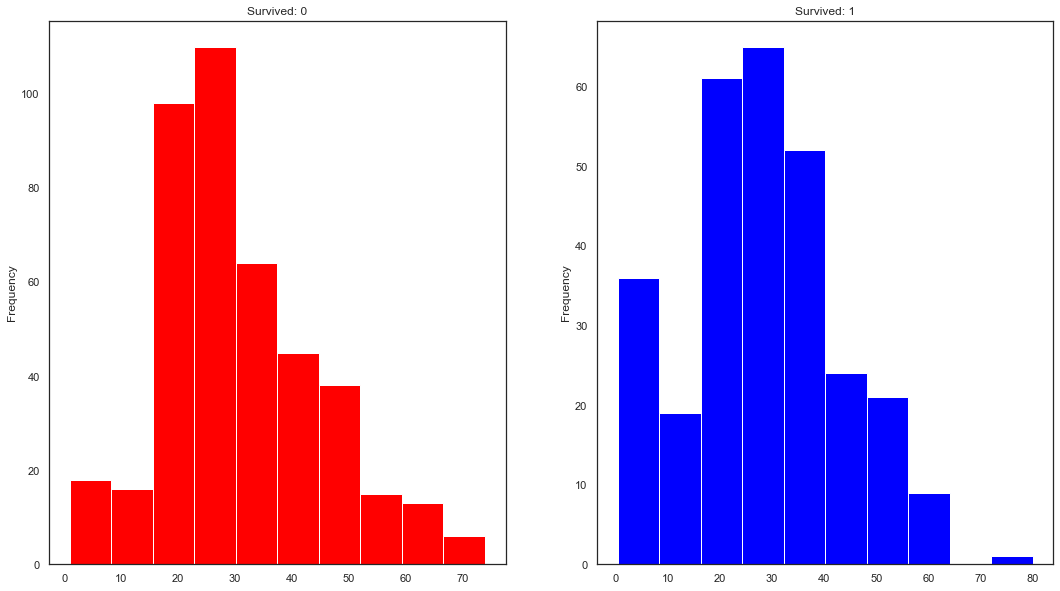

In [14]:
f, ax = plt.subplots(1,2, figsize=(18,10))

train[train['Survived']==0]['Age'].plot.hist(ax=ax[0], color='red')
ax[0].set_title('Survived: 0')

train[train['Survived']==1]['Age'].plot.hist(ax=ax[1], color='blue')
ax[1].set_title('Survived: 1')
plt.show()

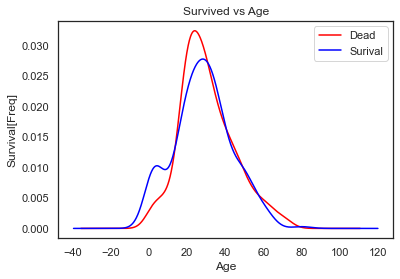

In [15]:
plt.title("Survived vs Age")
train[train['Survived']==0]['Age'].plot.kde(color='red', label='Dead')
train[train['Survived']==1]['Age'].plot.kde(color='blue', label='Surival')
plt.legend()
plt.ylabel('Survival[Freq]')
plt.xlabel('Age')
plt.show()

- 관측결과:
1) 약 10-20세(2개의 bins) 사이의 연령은 많이 생존함 특히, 0~10세 사이가 두드러짐
2) 60대 이상의 노인층은 거의 생존 못하심...
3) 젊은 층(20-40)은 반반
4) 생존과 나이의 증가(혹은 감소)는 직접적인 상관관계는 없지만 1, 2를 바탕으로 영향을 준다는 것은 알 수 있음

### Fare

In [16]:
train['Fare'].isnull().sum()

0

In [17]:
train['Fare'].skew()

5.058014586919519

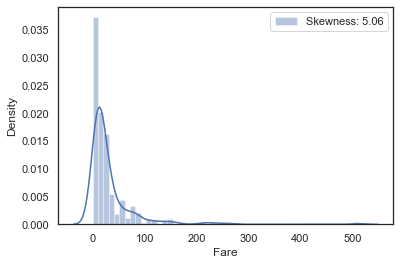

In [18]:
sns.distplot(train['Fare'], label=f'Skewness: %.2f'%(train['Fare'].skew()) )
plt.legend()
plt.show()

In [19]:
train['Fare'].fillna(train['Fare'].median(), inplace=True)

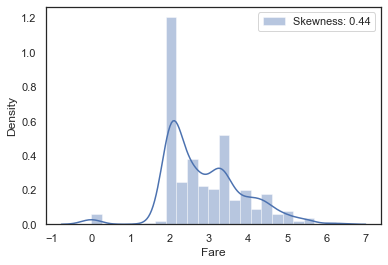

In [20]:
train['Fare'] = train['Fare'].map(lambda x: np.log(x) if x>0 else 0)
sns.distplot(train['Fare'], label=f'Skewness: %.2f'%(train['Fare'].skew()))
plt.legend()
plt.show()

- 관측 결과:
1) 굉장히 한쪽으로 치우친 것을 확인할 수 있다.
2) 이를 바탕으로 결측 값은 최빈값(median)으로 처리한다.
3) 모델을 학습할 때, overweight를 야기시킬 수 있음(skew)
4) log를 적용하여 펴주는 효과

## 3.2 Categorical values

### Sex

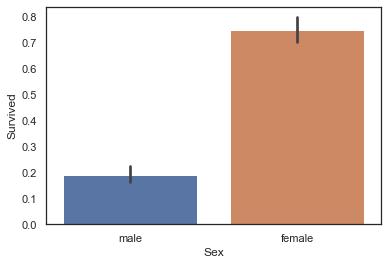

In [21]:
# f, ax = plt.subplots(1, 2, figsize=(18,8))
sns.barplot('Sex', 'Survived', data=train)
plt.show()

In [22]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 관측결과:
1) 남성이 여성보다 생존률이 낮음
2) 이는 생존 예측에 굉장히 중요한 변수로 작동함
3) Women and children first in 1997

### Pclass

In [23]:
pd.crosstab(train.Pclass, train.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,79,134,213
2,97,87,184
3,365,119,484
All,541,340,881


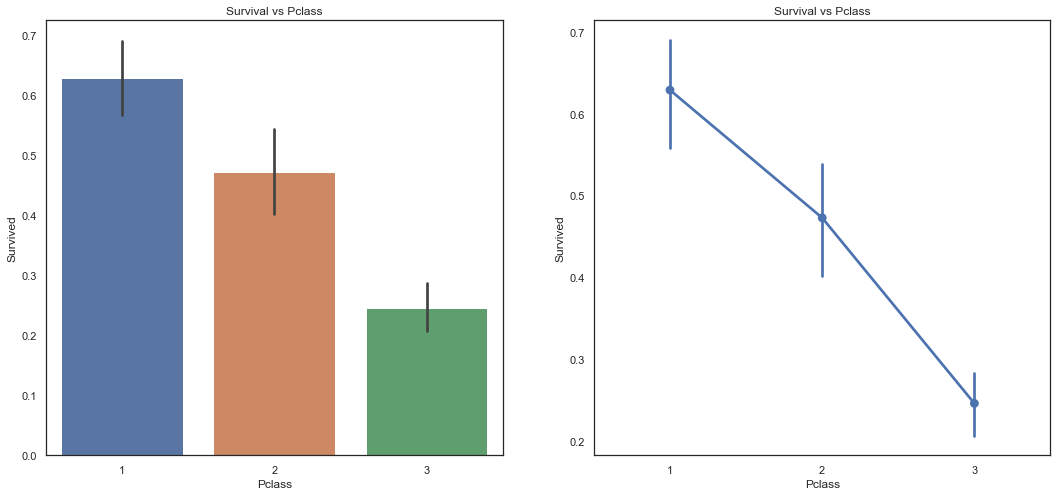

In [24]:
f, ax = plt.subplots(1,2, figsize=(18,8))
sns.barplot('Pclass', 'Survived', data=train, ax=ax[0])
ax[0].set_title('Survival vs Pclass')
sns.pointplot('Pclass', 'Survived', data=train, ax=ax[1])
ax[1].set_title('Survival vs Pclass')
plt.show()

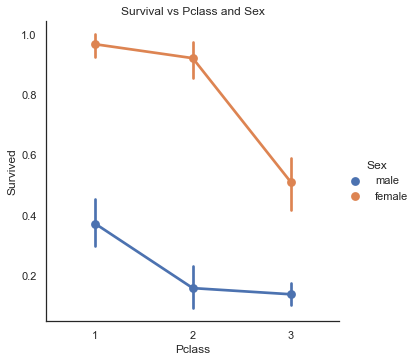

In [25]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=train)
plt.title('Survival vs Pclass and Sex')
plt.show()

1 class | Fare average:[4.05779615] std:[0.94339143]
2 class | Fare average:[2.83105883] std:[0.7109209]
3 class | Fare average:[2.36938184] std:[0.57073771]


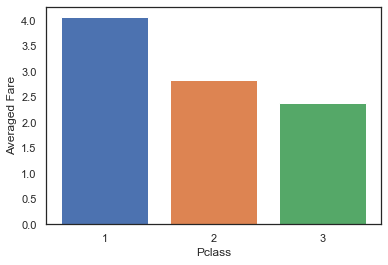

In [26]:
mean, std = train[['Pclass','Fare']].groupby('Pclass').mean(), train[['Pclass','Fare']].groupby('Pclass').std()
for i in range(3):
    print(f'{i+1} class | Fare average:{mean.values[i]} std:{std.values[i]}')
    plt.bar(str(i+1), mean.values[i][0])
    
plt.xlabel('Pclass')
plt.ylabel('Averaged Fare')
plt.show()

- 관측 결과:
1) 등급이 높을 수록 생존률이 떨어진다
2) 좌석 등급(Pclass) $\rightarrow$ 요금(Fare)

### Embarked

In [27]:
train['Embarked'].isnull().sum()

2

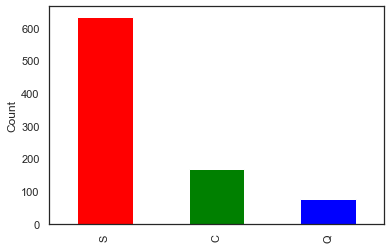

In [28]:
train['Embarked'].value_counts().plot.bar(color=['red','green','blue'])
plt.ylabel('Count')
plt.show()

In [29]:
train['Embarked'].fillna('S', inplace=True)

In [30]:
train.Embarked, train.Survived

(0      S
 1      C
 2      S
 3      S
 4      S
       ..
 886    S
 887    S
 888    S
 889    C
 890    Q
 Name: Embarked, Length: 881, dtype: object,
 0      0
 1      1
 2      1
 3      1
 4      0
       ..
 886    0
 887    1
 888    0
 889    1
 890    0
 Name: Survived, Length: 881, dtype: int64)

In [31]:
pd.crosstab(train.Embarked, train.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Embarked,,,
C,75,93,168
Q,47,30,77
S,419,217,636
All,541,340,881


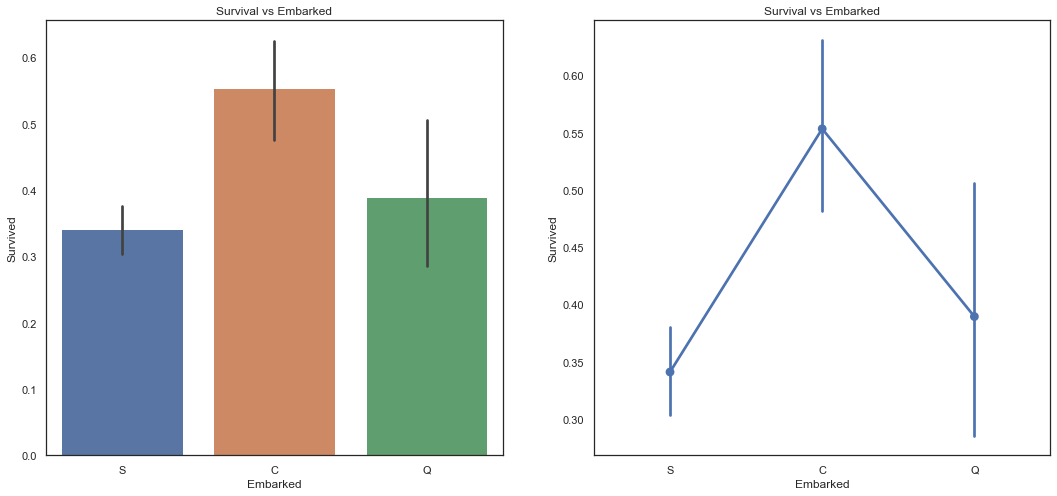

In [32]:
f, ax = plt.subplots(1,2, figsize=(18,8))

sns.barplot('Embarked', 'Survived', data=train, ax=ax[0])
ax[0].set_title('Survival vs Embarked')

sns.pointplot('Embarked', 'Survived', data=train, ax=ax[1])
ax[1].set_title('Survival vs Embarked')

plt.show()


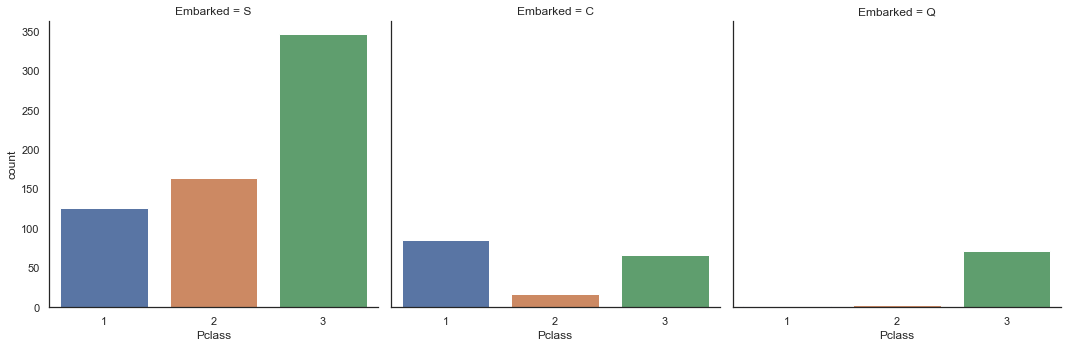

In [33]:
sns.factorplot('Pclass', col='Embarked', data=train, kind='count')
plt.show()

- 관측결과:
1) C가 가장 많이 살았고 S가 가장 많이 죽음
2) C의 경우 확실히 class1의 비율이 많음 $\rightarrow$ 많이 생존 원인
3) S의 경우 class3의 비율이 압도적임 $\rightarrow$ 많이 죽은 원인
4) Q의 경우 class3의 비율이 압도적인데 많이 살았음(행운인듯?)

## 4. Filling missing values

### 4.1 Age
전체 데이터 셋에는 256개의 결측값이 존재. 이를 해결하기 위해 나이와 관견된 Sex, Parch, Pclass and SibSp을 살펴보자

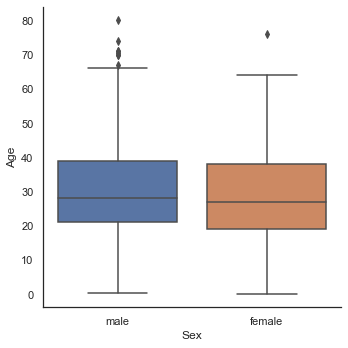

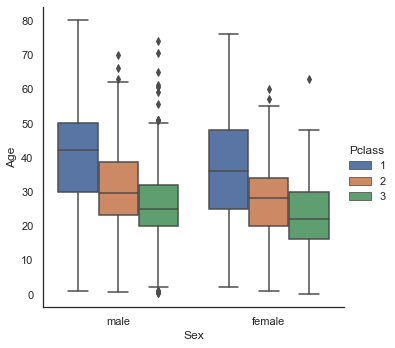

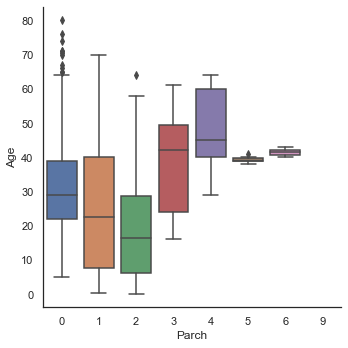

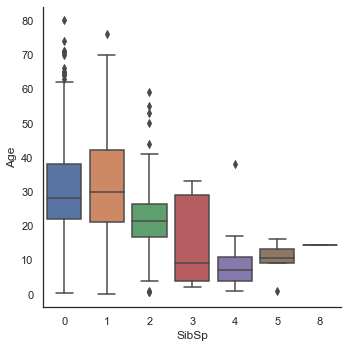

In [34]:
sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

- 관측 결과:
1) 나이는 남성과 여성의 하위인구와 유사한 모습. 적절하지 않음
2) Pclass에 따라 음의 상관 관계를 보임

In [35]:
# convert Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})


<AxesSubplot:>

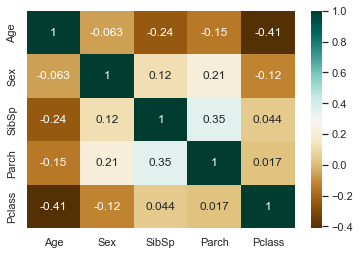

In [36]:
cols = ['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']
corr = dataset[cols].corr()
sns.heatmap(corr, cmap='BrBG', annot=True)

상관 관계 히트맵은 나이는 성별과 관련이 없고 Pclass, SibSp, Parch와 음의 상관 관계를 보임을 보인다.

나이의 증가는 부모/자식의 수의 증가와 같다. 하지만 일반적으로 음의 상관

그래서 SibSp, Parch, Pclass를 이용해서 age의 결측 값을 처리한다.

나이를 Pclass, Parch, SibSp에 따라 유사한 행의 최빈값으로 이뤄진다


In [37]:
### Filling Age with the median age of similar rows according to Pclass, Parch and SibSp

index_NaN_age = list(dataset[dataset['Age'].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"])
                               & (dataset['Parch'] == dataset.iloc[i]["Parch"])
                               & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))
                             ].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med


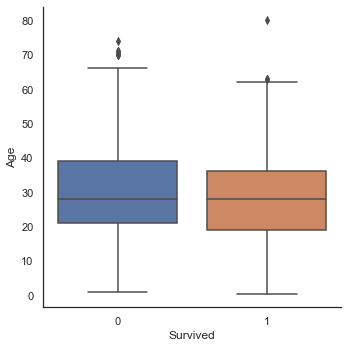

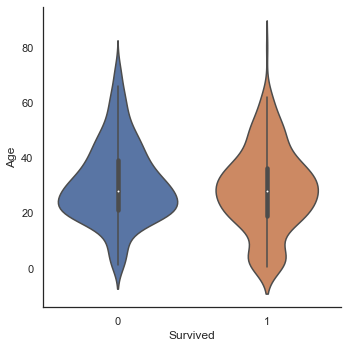

In [38]:
sns.factorplot(x='Survived', y='Age', data=train, kind='box')
sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

- 관측결과:

생존한 하위 집단과 생존하지 않은 하위 집단에서 연령의 중앙값 사이에는 차이가 없습니다.

그러나 생존한 승객의 바이올린 플롯에서 우리는 여전히 아주 어린 승객의 생존율이 더 높다는 것을 알 수 있습니다.

### 5. Feature engineering
5.1 Name/Title

In [39]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [40]:
# Get title from Name
dataset_title = []
for i in dataset['Name']:
    dataset_title.append(i.split(',')[1].split('.')[0].strip())
    
dataset['Title'] = pd.Series(dataset_title)
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,Mr


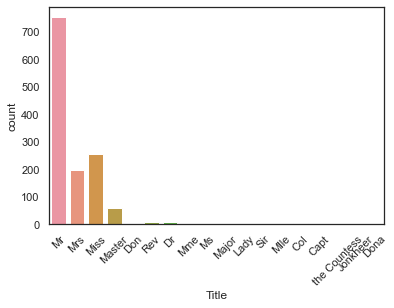

In [41]:
g = sns.countplot('Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [42]:
dataset['Title'].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [43]:
dataset['Title'].value_counts().keys()

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Rev', 'Dr', 'Col', 'Mlle', 'Major',
       'Ms', 'Lady', 'Sir', 'Mme', 'Don', 'Capt', 'the Countess', 'Jonkheer',
       'Dona'],
      dtype='object')

<AxesSubplot:xlabel='Title', ylabel='count'>

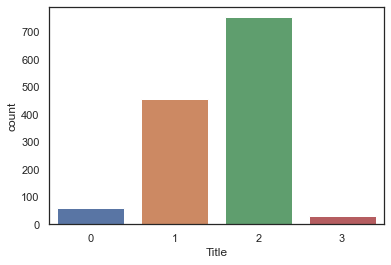

In [44]:
# 총 17개 있는데 대부분 몇개 없음 따라서 묶어주자
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

sns.countplot(dataset['Title'])


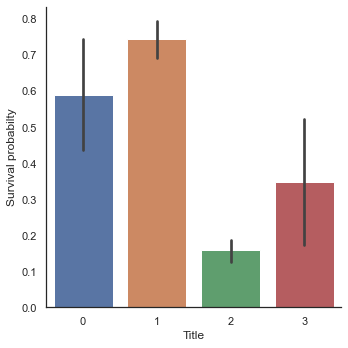

In [45]:
sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
plt.ylabel('Survival probabilty')
plt.show()

In [46]:
dataset.drop(labels='Name', axis=1, inplace=True)

### 5.2 Family size
앞의 eda를 통해 가족의 규모가 커질수로 생존확률이 떨어지는 것을 알 수 있습니다. 그래서 나는 "Fize"(family size)라는 변수를 만들어서 SibSp, Parch and 1을 더한 값을 넣을 것이다

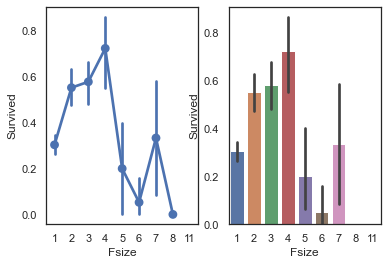

In [47]:
dataset['Fsize'] = dataset['SibSp']+dataset['Parch']+1
f, ax = plt.subplots(1,2)
sns.pointplot(y='Survived', x='Fsize', data=dataset, ax=ax[0])
sns.barplot(y='Survived', x='Fsize', data=dataset,  ax=ax[1])
plt.show()

가족의 규모는 중요한 역할을 하여 생존확룰은 큰 가족이면 더 떨어질 것이다.
그런데 아예 혼자 온 사람은 오히려 생존확률이 1~3보다 떨어지니 그것도 따로 고려.
이에 따라 4가지 카테고리고 나누어준다

In [48]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3<=s<=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF
0,1,0.0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,2,2,0,1,0,0
1,2,1.0,1,1,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,1,0,0,0
3,4,1.0,1,1,35.0,1,0,113803,53.1000,C123,S,1,2,0,1,0,0
4,5,0.0,3,0,35.0,0,0,373450,8.0500,NaN,S,2,1,1,0,0,0


Text(0.5, 1.0, 'Survival vs Large Famliy')

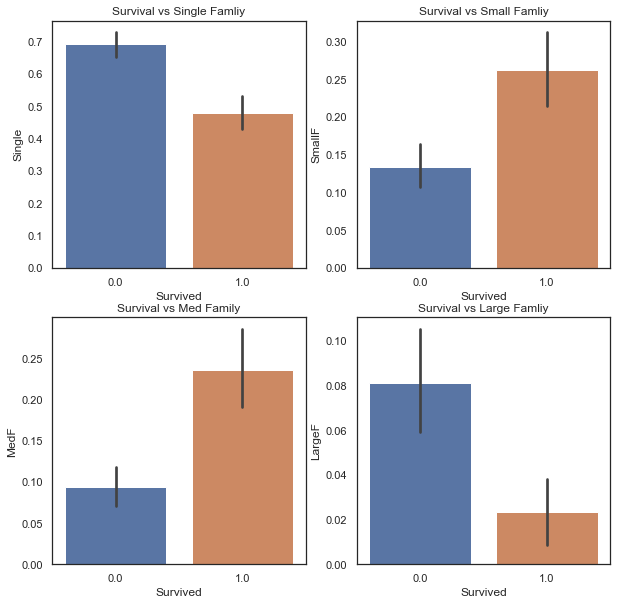

In [49]:
f, ax = plt.subplots(2,2, figsize=(10,10))
sns.barplot('Survived', 'Single', data=dataset, ax=ax[0,0])
ax[0,0].set_title('Survival vs Single Famliy')

sns.barplot('Survived', 'SmallF', data=dataset, ax=ax[0,1])
ax[0,1].set_title('Survival vs Small Famliy')

sns.barplot('Survived', 'MedF', data=dataset, ax=ax[1,0])
ax[1,0].set_title('Survival vs Med Family')
                
sns.barplot('Survived', 'LargeF', data=dataset, ax=ax[1,1])
ax[1,1].set_title('Survival vs Large Famliy')

Medium families have more chance to survive than single passenger and large families.

In [50]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,71.2833,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,53.1000,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,8.0500,NaN,...,0,0,0,0,0,1,0,0,0,1


5.3 Cabin

In [51]:
dataset['Cabin']

0        NaN
1        C85
2        NaN
3       C123
4        NaN
        ... 
1294     NaN
1295    C105
1296     NaN
1297     NaN
1298     NaN
Name: Cabin, Length: 1299, dtype: object

In [52]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [53]:
dataset['Cabin'].isnull().sum()

1007

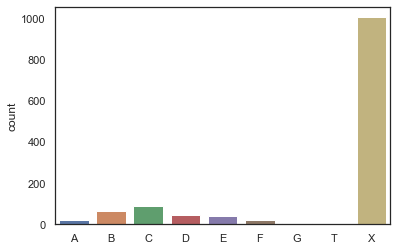

In [54]:
cabin = []
for i in dataset['Cabin']:
    if not pd.isnull(i):
        cabin.append(i[0])
    else:
        cabin.append('X')
cabin= pd.Series(cabin)
sns.countplot(cabin, order=['A','B','C','D','E','F','G','T','X'])
dataset['Cabin']=cabin

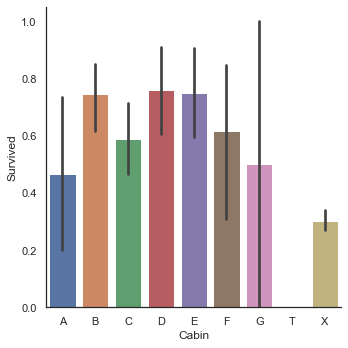

In [55]:
sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
plt.show()

In [56]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,7.2500,2,...,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,71.2833,2,...,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,7.9250,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,53.1000,2,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,373450,8.0500,1,...,1,0,0,0,0,0,0,0,0,1


5.4 Ticket

In [57]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [58]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [59]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,7.2500,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,71.2833,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,7.9250,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,53.1000,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,8.0500,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


### 6. Modeling

In [60]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)


In [61]:
train['Survived'] = train['Survived'].astype(int)
y_train = train['Survived']
x_train = train.drop(labels=['Survived'], axis=1)

In [62]:
x_train.shape, y_train.shape

((881, 66), (881,))

### 6.1 Simple Modeling
- 6.1.1 Cross validation models
1) SVC
2) Decision Tree
3) AdaBoost
4) Extra Trees
5) Gradient Boosting
6) Multiple layer perceptron
7) KNN
8) Logistic regression
9) Linear Discriminant Analysis

In [77]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)
kfold

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [96]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
random_state=2
classifiers=[]
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=random_state),
                                    random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [97]:
from sklearn.model_selection import cross_val_score

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, x_train, y_train, cv=kfold, n_jobs=-1, scoring='accuracy'))

In [98]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [99]:
len(classifiers)

10

In [100]:
cv_res = pd.DataFrame({
    'CrossValMeans': cv_means,
    'CrossValerrors':cv_std,
    'Algorithms':["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]
})
cv_res

,CrossValMeans,CrossValerrors,Algorithms
0,0.684525,0.050946,SVC
1,0.802592,0.037380,DecisionTree
2,0.799170,0.052417,AdaBoost
3,0.801392,0.047049,RandomForest
4,0.805950,0.048891,ExtraTrees
5,0.827464,0.041550,GradientBoosting
6,0.813841,0.037444,MultipleLayerPerceptron
7,0.731014,0.036793,KNeighboors
8,0.825204,0.036330,LogisticRegression
9,0.826328,0.037728,LinearDiscriminantAnalysis


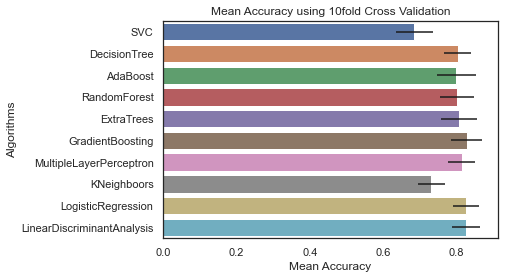

In [113]:
sns.barplot(x='CrossValMeans', y='Algorithms', data=cv_res, orient ='h', **{'xerr':cv_std})
plt.title("Mean Accuracy using 10fold Cross Validation")
plt.xlabel('Mean Accuracy')
plt.show()

I decided to choose the MultipleLayerPerceptron, LogisticRegression, GradientBoosting and LinearDiscriminantAnalysis classifiers for the ensemble modeling.

### 6.1.2 Hyperparameter Tuning for best models
Grid search optimization을 이용해서 MultipleLayerPerceptron, LogisticRegression, GradientBoosting and RandomForest parameter를 조정해 성능을 향상시키자

In [144]:
from sklearn.model_selection import GridSearchCV
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [155]:
MLP_params = {
    'batch_size':[32],
    'hidden_layer_sizes':[(64,64,64), (64,128,64),(128,128,128)],
    'activation':['logistic', 'tanh', 'relu'], 
    'solver':['tanh','adam'],
    'alpha':[1e-4, 1e-3], # model penalty 
    'learning_rate':['constant','adaptive'],
    'max_iter':[100, 200, 300],
    
}
# model
MLP = MLPClassifier(early_stopping=True)
gridMLP = GridSearchCV(estimator=MLP, param_grid=MLP_params, cv=kfold, 
                       scoring='accuracy', n_jobs=-1, verbose=1)
gridMLP.fit(x_train, y_train)
print("The best is", gridMLP.best_estimator_)
print("The score is", gridMLP.best_score_)
# 0.813841

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
The best is MLPClassifier(activation='logistic', batch_size=32, early_stopping=True,
              hidden_layer_sizes=(64, 128, 64), learning_rate='adaptive')
The score is 0.8195364663585002


In [159]:
LR_params={
    'C':[10,5,1,0.1,0.001],
    'penalty':['none', 'l1','l2','elasticnet']
}
LR = LogisticRegression()
gridLR = GridSearchCV(estimator=LR, param_grid=LR_params, cv=kfold, 
                      scoring='accuracy', n_jobs=-1,verbose=1)
gridLR.fit(x_train, y_train)
print("The best is", gridLR.best_estimator_)
print("The score is", gridLR.best_score_)
# 0.825204 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
The best is LogisticRegression(C=10)
The score is 0.8217835130970723


In [162]:
# learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10
GBM_params={
    'learning_rate':[0.1,0.01,0.001],
    'n_estimators':[100,150,200],
    'max_depth':[5, 7, 9],
    'loss':['deviance']
    
}
GBM = GradientBoostingClassifier()
gridGBM = GridSearchCV(estimator=GBM, param_grid=GBM_params, cv=kfold,
                      scoring='accuracy', n_jobs=-1, verbose=1)
gridGBM.fit(x_train, y_train)

print("The best is", gridGBM.best_estimator_)
print("The score is", gridGBM.best_score_)
# 0.827464 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
The best is GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=200)
The score is 0.8286081150487931


In [164]:
RF_params = {
    'n_estimators':[100, 150, 200],
    'max_depth':[5, 7, 9],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,3,4,5] 
}
RF = RandomForestClassifier()
gridRF = GridSearchCV(estimator=RF, param_grid=RF_params, cv=kfold,
                     scoring='accuracy', n_jobs=-1, verbose=1)
gridRF.fit(x_train, y_train)

print("The best is", gridRF.best_estimator_)
print("The score is", gridRF.best_score_)
# 0.801392 

Fitting 5 folds for each of 135 candidates, totalling 675 fits
The best is RandomForestClassifier(max_depth=5, n_estimators=150)
The score is 0.8331535695942476


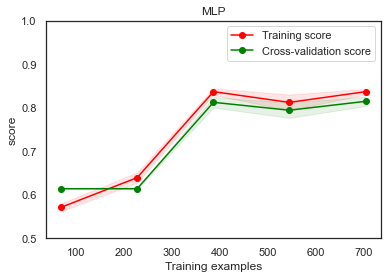

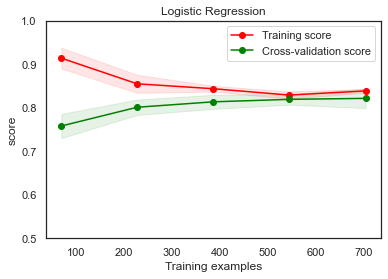

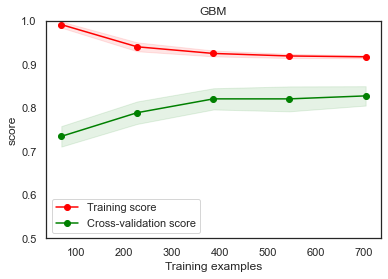

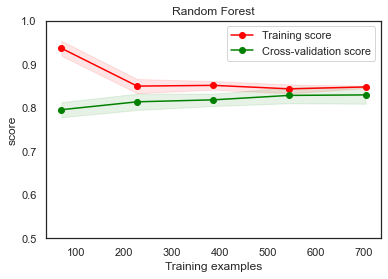

In [182]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, x, y, kfold):
    train_sizes, train_scores, test_scores = learning_curve(estimator.best_estimator_, x, y, cv=kfold, n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', color='red', label="Training score")
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color='red')
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-validation score")
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color='green')
    
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('score')
    plt.ylim([0.5,1])
    plt.legend()
    plt.show()

    
models = [gridMLP, gridLR, gridGBM, gridRF]
titles = ['MLP', 'Logistic Regression', 'GBM', 'Random Forest']
for i in range(4):
    model = models[i]
    title = titles[i]
    plot_learning_curve(model, title, x_train, y_train, kfold)